In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
import GPy

# Initialise data

In [3]:
lb = -5
ub = 5
y_min = -3
y_max = 3

In [4]:
mu = 0
ell = 1
sn = 0.5
sy = np.exp(-6)

In [5]:
def resetData():
    X_train = np.array([])
    y_train = np.array([])
    X_train = X_train.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    
    n_test = 100
    X_test = np.linspace(lb,ub,n_test)
    X_test = X_test.reshape(-1,1)
    mu_test = np.ones((n_test,1))*mu
    s2_test = np.ones((n_test,1))*sn**2
    s_test = np.sqrt(s2_test)
    return X_train, y_train, X_test, mu_test, s_test

# Initialise GP kernel

In [6]:
def initialiseGP(X_train,y_train):
    # Choose a kernel, here we use a squared exponential kernel
    k = GPy.kern.RBF(1, variance=sn, lengthscale=ell)
    m = GPy.models.GPRegression(X_train,y_train,k, noise_var=np.exp(-6))
    return m

In [7]:
def addTrainingPoint(X_train,y_train,x_new,y_new):    
    X_train = np.append(X_train,x_new)
    y_train = np.append(y_train,y_new)
    return X_train.reshape(-1,1), y_train.reshape(-1,1)

In [24]:
%%capture
%matplotlib inline
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"

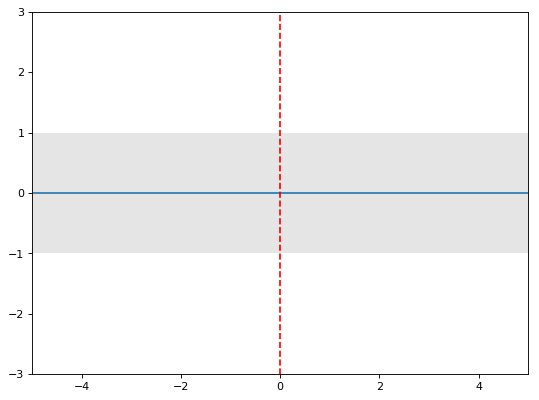

In [49]:
# Reset data
X_train, y_train, X_test, mu_test, s_test = resetData()

firstPoint = True
x_new = 0
mu_new = 0 
s_new = 1

# Initialise plot
fig,ax = plt.subplots(1,1, figsize=(8, 6), dpi=80)
ax.set_xlim(lb,ub)
ax.set_ylim(y_min,y_max)
#def init():
line_post, = ax.plot(X_test,mu_test)
line_next = ax.axvline(x_new,y_min,y_max,color='r', linestyle="dashed")
pts_train, = ax.plot(X_train,y_train,'rx', label="training points")
ax.fill_between(np.squeeze(X_test), np.squeeze(mu_test-2*s_test), np.squeeze(mu_test+2*s_test), facecolor='grey', alpha=0.2)
#plt.legend()

#add_button = ipywidgets.Button(description="Add training point")
#reset_button = ipywidgets.Button(description="Reset")
figsize(5, 3)

def addAndRetrain():
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,firstPoint,m
    # Add new training point based on x_new
    y_new = np.random.normal(mu_new, s_new)
    X_train,y_train = addTrainingPoint(X_train,y_train,x_new,y_new) 
    if firstPoint:
        firstPoint = False
        m = initialiseGP(X_train,y_train)   
    retrain()
    replot()

def reset():
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,firstPoint,m
    # Add new training point based on x_new
    X_train, y_train, X_test, mu_test, s_test = resetData()
    firstPoint = True
    x_new = 0
    mu_new = 0 
    s_new = 1
    replot()
    
def retrain():
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,m
    # Sample next training point
    x_new = np.random.uniform(low=lb, high=ub, size=1) 
    mu_new, s2_new = m.predict(x_new.reshape(-1,1))
    s_new = np.sqrt(s2_new)
    
    # Update training data
    m.set_XY(X_train,y_train)
    
    # Generate predictions
    mu_test, s2_test = m.predict(X_test)
    s_test = np.sqrt(s2_test)

def replot():
    # Update plot
    for coll in (ax.collections): ax.collections.remove(coll)
    line_post.set_data(X_test,mu_test)
    pts_train.set_data(X_train,y_train)
    line_next.set_xdata(x_new)
    ax.fill_between(np.squeeze(X_test), np.squeeze(mu_test-2*s_test), np.squeeze(mu_test+2*s_test), facecolor='grey', alpha=0.2)
    fig.canvas.draw()

def animate(i):
    if i == 0: reset()
    else: addAndRetrain()

ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=reset, frames=10, interval = 1000)


In [50]:
ani

<IPython.core.display.Javascript object>


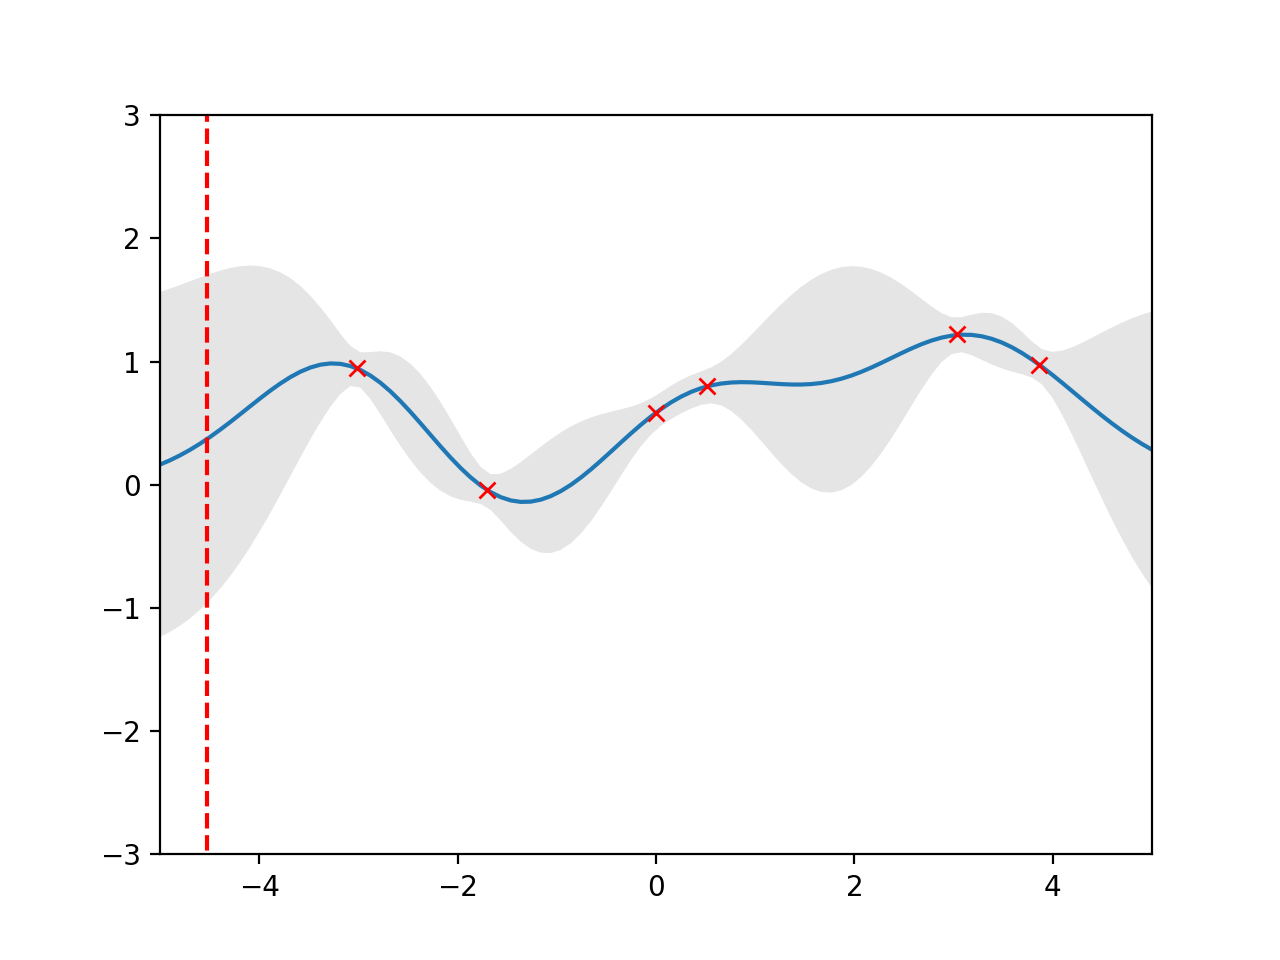

A Jupyter Widget

A Jupyter Widget

In [8]:
import ipywidgets
from IPython.core.pylabtools import figsize

# Reset data
X_train, y_train, X_test, mu_test, s_test = resetData()

firstPoint = True
x_new = 0
mu_new = 0 
s_new = 1

# Initialise plot
fig,ax = plt.subplots(1,1)
ax.set_xlim(lb,ub)
ax.set_ylim(y_min,y_max)

line_post, = ax.plot(X_test,mu_test)
line_next = ax.axvline(x_new,y_min,y_max,color='r', linestyle="dashed")
pts_train, = ax.plot(X_train,y_train,'rx', label="training points")
plt.fill_between(np.squeeze(X_test), np.squeeze(mu_test-2*s_test), np.squeeze(mu_test+2*s_test), facecolor='grey', alpha=0.2)
#plt.legend()

add_button = ipywidgets.Button(description="Add training point")
reset_button = ipywidgets.Button(description="Reset")
figsize(5, 3)

def addAndRetrain(b):
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,firstPoint,m
    # Add new training point based on x_new
    y_new = np.random.normal(mu_new, s_new)
    X_train,y_train = addTrainingPoint(X_train,y_train,x_new,y_new) 
    if firstPoint:
        firstPoint = False
        m = initialiseGP(X_train,y_train)   
    retrain()
    replot()

def reset(b):
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,firstPoint,m
    # Add new training point based on x_new
    X_train, y_train, X_test, mu_test, s_test = resetData()
    firstPoint = True
    x_new = 0
    mu_new = 0 
    s_new = 1
    replot()
    
def retrain():
    global X_train,y_train,mu_test,s_test,x_new,mu_new,s_new,m
    # Sample next training point
    x_new = np.random.uniform(low=lb, high=ub, size=1) 
    mu_new, s2_new = m.predict(x_new.reshape(-1,1))
    s_new = np.sqrt(s2_new)
    
    # Update training data
    m.set_XY(X_train,y_train)
    
    # Generate predictions
    mu_test, s2_test = m.predict(X_test)
    s_test = np.sqrt(s2_test)

def replot():
    # Update plot
    for coll in (ax.collections): ax.collections.remove(coll)
    line_post.set_data(X_test,mu_test)
    pts_train.set_data(X_train,y_train)
    line_next.set_xdata(x_new)
    plt.fill_between(np.squeeze(X_test), np.squeeze(mu_test-2*s_test), np.squeeze(mu_test+2*s_test), facecolor='grey', alpha=0.2)
    fig.canvas.draw()
    
add_button.on_click(addAndRetrain)
reset_button.on_click(reset)
display(add_button)
display(reset_button)